# Downloading the OpenAQ Air Pollution dataset

In [1]:
# Uncomment below to download the Open AQ dataset from Amazon
#!pip install awscli
#!~/.local/bin/aws s3 cp --no-sign-request s3://openaq-data-archive/records/csv.gz/ dataset --recursive

# Now that the download is over, let's do some Air Pollution Data Exploration!

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import os
import sys
from pyspark.sql import SparkSession
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession


# --- Creating a spark session ---
# SDSC limits: 128 executors, 250 GB memory-

# SET: use to the values used to start this SDSC Jupyter session
node_memory = 80
node_cores = 40

# SET: how many cores you want allocated to the driver node
driver_cores = 10


executor_cores = node_cores - driver_cores
executor_memory = node_memory // executor_cores
driver_memory = node_memory - (executor_cores * executor_memory)

spark = SparkSession.builder \
    .config("spark.driver.memory", f'{driver_memory}g') \
    .config("spark.executor.memory", f'{executor_memory}g')\
    .config('spark.executor.instances', executor_cores) \
    .getOrCreate()

In [9]:
# Importing libraries
import numpy as np 
import pandas as pd 
import os
import sys

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql import SparkSession
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark import SparkContext
from pyspark.sql import SparkSession

# Creating a SparkContext instance 
sc = SparkContext()

# Creating a spark session
spark = SparkSession.builder.appName('232 Project').getOrCreate()

Matplotlib created a temporary cache directory at /tmp/matplotlib-3ey4ll0c because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by getOrCreate at /tmp/ipykernel_226390/3748049819.py:32 

# Files from AWS were in csv.gz formats. We need to decompress these files to csv files.

In [34]:
# Create a folder to put the unzipped csv files
#!mkdir -p combined_csv_files

In [37]:
# This will find the .csv.gz files and unzip them then copy that to the folder
#!find ../data/ -type f -name "*.csv" -exec gunzip -c {} \; -exec cp {} combined_csv_files/ \;

In [4]:
# Print the current working directory to get path
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /expanse/lustre/projects/uci150/ameek1


# Loading the Parquet file

In [2]:
# This will grab the data someone in the group has already downloaded. 
#path = "/expanse/lustre/projects/uci150/cmerry/data/records/csv.gz/country=us"  
parquet_path = "/expanse/lustre/projects/uci150/slin17/project/parquet_data"
df = spark.read.parquet(parquet_path)

In [3]:
df.columns

['location_id',
 'sensors_id',
 'location',
 'datetime',
 'lat',
 'lat.1',
 'lon',
 'lon.1',
 'parameter',
 'units',
 'value']

### Finding the total count of data from all parquet files, we have a lot!

In [6]:
df.count()

941941144

In [8]:
# show schema
df.printSchema()

root
 |-- location_id: long (nullable = true)
 |-- sensors_id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lat.1: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lon.1: double (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: double (nullable = true)



In [7]:
# Showing a portion of the dataframe 
df.show()

+-----------+----------+----------------+--------------------+---------+-----+-----------+-----+---------+-----+-----+
|location_id|sensors_id|        location|            datetime|      lat|lat.1|        lon|lon.1|parameter|units|value|
+-----------+----------+----------------+--------------------+---------+-----+-----------+-----+---------+-----+-----+
|        615|      1077|Queen Valley-615|2016-03-10T01:00:...|33.289398| NULL|-111.292801| NULL|       o3|  ppm| 0.04|
|        615|      1077|Queen Valley-615|2016-03-11T08:00:...|33.289398| NULL|-111.292801| NULL|       o3|  ppm|0.044|
|        615|      1077|Queen Valley-615|2016-03-11T09:00:...|33.289398| NULL|-111.292801| NULL|       o3|  ppm|0.049|
|        615|      1077|Queen Valley-615|2016-03-11T10:00:...|33.289398| NULL|-111.292801| NULL|       o3|  ppm|0.048|
|        615|      1077|Queen Valley-615|2016-03-11T11:00:...|33.289398| NULL|-111.292801| NULL|       o3|  ppm|0.055|
|        615|      1077|Queen Valley-615|2016-03

# Preprocessing Data

### Drop unused columns

Some source files have errant lat.1 and lon.1 columns. They are all NULL for all rows, and can be safely dropped.

In [4]:
# drop lat.1 and lon.1
df = df.drop('lat.1', 'lon.1')

### Checking for Nulls

In [5]:
# Are there any null values? 
from pyspark.sql.functions import isnan, when, count, col

df.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+-----------+----------+--------+--------+---+---+---------+-----+-----+
|location_id|sensors_id|location|datetime|lat|lon|parameter|units|value|
+-----------+----------+--------+--------+---+---+---------+-----+-----+
|          0|         0|49755799|       0|  3|  3|   582285|    0|    0|
+-----------+----------+--------+--------+---+---+---------+-----+-----+



In [6]:
# remove nulls from chosen columns
df = df.na.drop(subset=['location','lat','lon','value', 'parameter'])

Now re-checking for nulls

In [7]:
df.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+-----------+----------+--------+--------+---+---+---------+-----+-----+
|location_id|sensors_id|location|datetime|lat|lon|parameter|units|value|
+-----------+----------+--------+--------+---+---+---------+-----+-----+
|          0|         0|       0|       0|  0|  0|        0|    0|    0|
+-----------+----------+--------+--------+---+---+---------+-----+-----+



### Drop rows with Value 0 or less

In [10]:
df.filter(F.col("value") <= 0).count()

86980986

In [11]:
# keep only values > 0
df = df.filter(F.col("value") > 0)

## Transforming the datetime col ie splitting the 'datetime' column into date and time and then dropping the 'datetime' column

In [22]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format, col
df = df.withColumn('date', date_format(col('datetime'), 'yyyy-MM-dd')) \
       .withColumn('time', date_format(col('datetime'), 'HH:mm:ss'))
df.show()

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|      date|    time|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|      10233|     33249|WNVLELSC-10233|2019-09-23 05:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|05:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 06:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|06:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 07:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|07:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 09:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|09:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 10:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|10

### As seen above here are null values in the longitude, units, and value. The fact that null values were present for units and values may indicate that the sensor was not working. 

In [25]:
# Looking at the dataframe of nulls 
from pyspark.sql.functions import col
# Create a condition to filter rows that contain at least one null value
condition = ' or '.join([f"{column_name} IS NULL" for column_name in df.columns])

# Filter the DataFrame
null_data_df = df.filter(condition)

# Show the result
null_data_df.show()

+-----------+----------+-------------+-------------------+---------+----+---------+-----+-----+----------+--------+
|location_id|sensors_id|     location|           datetime|      lat| lon|parameter|units|value|      date|    time|
+-----------+----------+-------------+-------------------+---------+----+---------+-----+-----+----------+--------+
|       1210|      2169|Geronimo-1210|2016-03-12 08:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|08:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 09:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|09:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 10:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|10:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 11:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|11:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 12:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|12:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 13:00:00|32.250000|NULL

The above shows that in most cases the three likely occur together. 

In [29]:
df = df.na.drop("any")
df.show()

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|      date|    time|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|      10233|     33249|WNVLELSC-10233|2019-09-23 05:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|05:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 06:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|06:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 07:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|07:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 09:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|09:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 10:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|10

# Checking for values below zero

In [30]:
# Seeing if there are any rows where the value of the sensor measurement is below zero 
import pyspark.sql.functions as func

df.filter(func.col("value") < 0).count()

225772

In [31]:
# Look at the dataframe of where the value is less than 0.
# Filter the DataFrame
value_less_0_df = df.filter(col("value") < 0)
value_less_0_df.show()

+-----------+----------+--------------------+-------------------+---------+-----------+---------+-----+---------+----------+--------+
|location_id|sensors_id|            location|           datetime|      lat|        lon|parameter|units|    value|      date|    time|
+-----------+----------+--------------------+-------------------+---------+-----------+---------+-----+---------+----------+--------+
|       1039|     25482| Pinal Air Park-1039|2019-02-06 20:00:00|32.508308|-111.308060|     pm10|µg/m³|-2.000000|2019-02-06|20:00:00|
|       1039|     25482| Pinal Air Park-1039|2019-03-12 21:00:00|32.508308|-111.308060|     pm10|µg/m³|-1.000000|2019-03-12|21:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 18:00:00|26.724167| -80.663055|     pm25|µg/m³|-2.100000|2016-07-26|18:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 19:00:00|26.724167| -80.663055|     pm25|µg/m³|-4.900000|2016-07-26|19:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 20:00:

## The value of a particular parameter should not be zero. Since these measurements are measures of mass in a given volume of air, the concept of negative mass wouldn't make sense and therefore the readings form the sensor should not be negative. This indicates there could be sensor malfunctions, ie. software or calibration errors.

In [32]:
# Filtering to keep all rows with 'value' greater than zero. 
df = df.filter(col("value") > 0)

In [33]:
# Saving as a pickle file for later
df.rdd.saveAsPickleFile("df_pkl_parsed")

In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DecimalType
# Loading the parsed pickled RDD
pickledRDD = spark.sparkContext.pickleFile("/expanse/lustre/projects/uci150/ameek1/df_pkl_parsed")
schema = StructType([
    StructField("location_id", IntegerType(), True),
    StructField("sensors_id", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("datetime", TimestampType(), True),
    StructField("lat", DecimalType(precision=10, scale=6), True),
    StructField("lon", DecimalType(precision=10, scale=6), True),
    StructField("parameter", StringType(), True),
    StructField("units", StringType(), True),
    StructField("value", DecimalType(precision=10, scale=6), True),
    StructField("date", StringType(), True),  
    StructField("time", StringType(), True)   

])
# Converting the RDD to a DataFrame
df = spark.createDataFrame(pickledRDD, schema)

# Graphing some data

In [47]:
# Filtering for sensor 1803 and parameter 'pm10'
filtered_df = df.filter((df.sensors_id == 1803) & (df.parameter == "pm10")).orderBy("datetime")

In [49]:
# Selecting datetime and value for the graph
pm10_data = filtered_df.select("datetime", "value").collect()

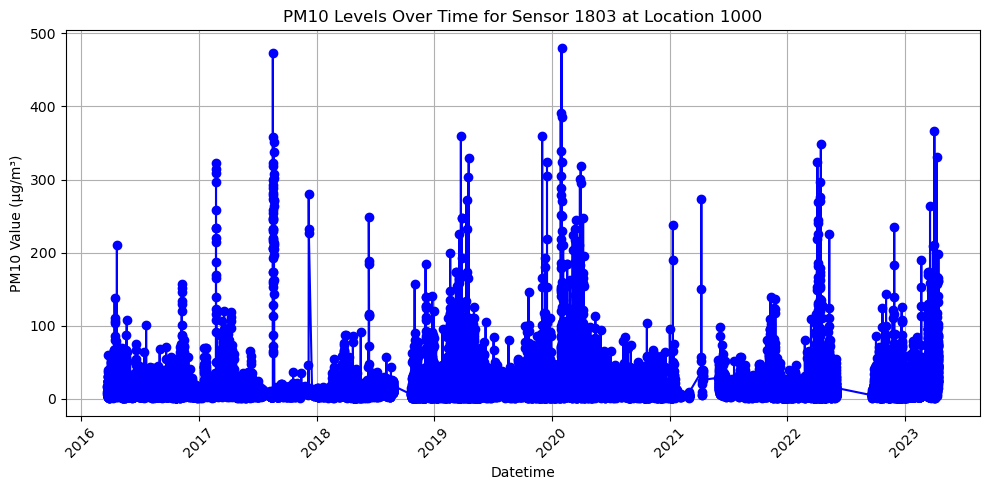

In [50]:
import matplotlib.pyplot as plt

# Extracting separate lists of dates and values and plotting it
dates = [data.datetime for data in pm10_data]
values = [data.value for data in pm10_data]
plt.figure(figsize=(10, 5))
plt.plot(dates, values, marker='o', linestyle='-', color='b')
plt.title("PM10 Levels Over Time for Sensor 1803 at Location 1000")
plt.xlabel("Datetime")
plt.ylabel("PM10 Value (µg/m³)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

From 2016 to 2023, we can see that the largest amounts of pollution for PM10 occurred at the beginning or end of the year. 

### Let's look at the averages of PM10 levels for Sensor 1803

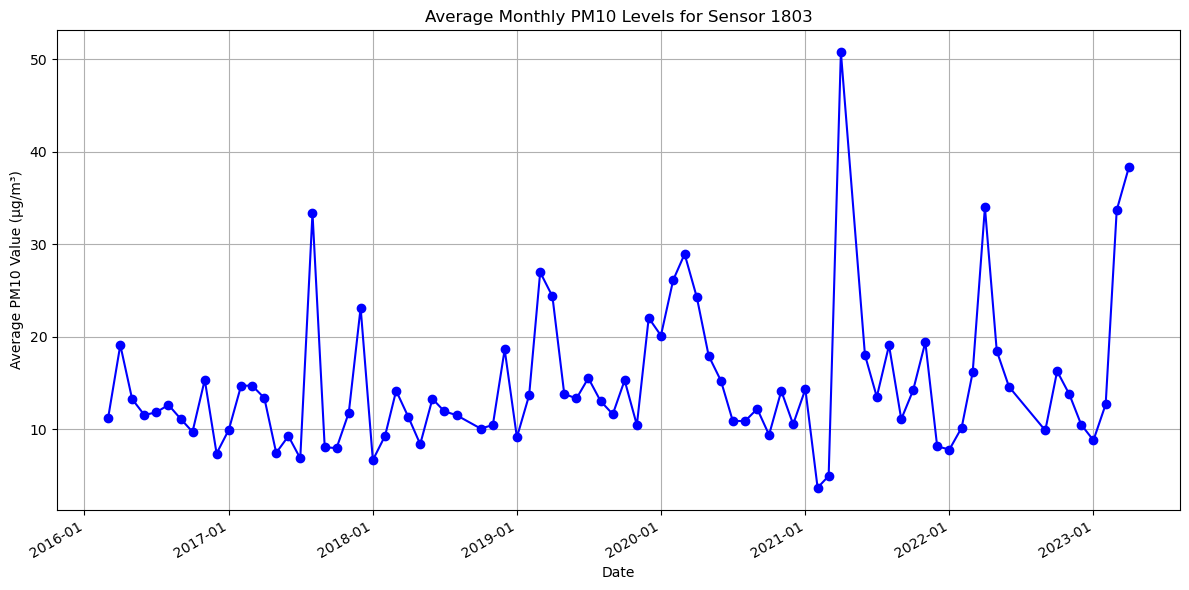

In [51]:
from pyspark.sql.functions import year, month, to_timestamp, avg
# Filtered the DF
filtered_df = df.filter((df.sensors_id == 1803) & (df.parameter == "pm10"))
#filtered_df = filtered_df.withColumn('datetime', to_timestamp('datetime', 'yyyy-MM-dd HH:mm:ss'))
# Add year and month columns for grouping
filtered_df = filtered_df.withColumn('year', year('datetime'))
filtered_df = filtered_df.withColumn('month', month('datetime'))
# Group by year and month, and calculate average values
monthly_avg_data = filtered_df.groupBy('year', 'month').agg(
    avg('value').alias('avg_value')
).orderBy('year', 'month')
monthly_avg_data = monthly_avg_data.collect()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.figure(figsize=(12, 6)) 
dates = [datetime(year=row['year'], month=row['month'], day=1) for row in monthly_avg_data]
values = [row['avg_value'] for row in monthly_avg_data]
plt.plot(dates, values, marker='o', linestyle='-', color='b')
plt.title("Average Monthly PM10 Levels for Sensor 1803")
plt.xlabel("Date")
plt.ylabel("Average PM10 Value (µg/m³)")
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate() 

plt.tight_layout()
plt.show()

# Looking at data with PySpark SQL

In [3]:
# Creating a temporary table to use with PySpark SQL
df.createOrReplaceTempView('pollution')

In [52]:
# Looking at the different number of parameters in the dataset
results = spark.sql("SELECT count(distinct parameter) as Parameter_Count \
                    FROM pollution")
results.show()

+---------------+
|Parameter_Count|
+---------------+
|              9|
+---------------+



In [54]:
# Looking at the sensor counts for each location. 
results = spark.sql("SELECT location_id, sensors_id, count(sensors_id) as Sensor_Count \
                    FROM pollution \
                    GROUP BY location_id, sensors_id \
                    ORDER BY location_id")
results.show()

+-----------+----------+------------+
|location_id|sensors_id|Sensor_Count|
+-----------+----------+------------+
|       1000|      1803|       36050|
|       1000|      1802|       30973|
|       1001|      1804|       20391|
|       1002|      1805|       26916|
|       1003|      1807|       36070|
|       1003|      1806|       26673|
|       1005|      1810|        7626|
|       1006|      1811|       28892|
|       1006|      1812|       21378|
|       1006|      1813|       41336|
|       1008|      1817|       33523|
|       1008|   2888356|        1169|
|       1009|      1818|       36226|
|       1010|      1834|       40699|
|       1010|      1821|       42431|
|       1010|      1819|       40721|
|       1010|     25511|        4936|
|       1011|      1822|        4607|
|       1011|      1820|        4745|
|       1012|      1823|       20130|
+-----------+----------+------------+
only showing top 20 rows



In [60]:
# Looking at the different number of parameters in the dataset
results = spark.sql("SELECT DISTINCT location_id, parameter, sensors_id\
                    FROM pollution")
results.show()

+-----------+---------+----------+
|location_id|parameter|sensors_id|
+-----------+---------+----------+
|       1109|       o3|      1987|
|       1074|       o3|      1926|
|       1503|     pm25|      2653|
|       1023|     pm10|      1846|
|       1054|       o3|      1891|
|       1459|     pm25|      2586|
|       1110|     pm25|      1989|
|       1538|     pm25|      2706|
|       1075|       o3|      1927|
|       1079|     pm25|      1932|
|       1097|     pm25|      5543|
|       1375|       co|      2465|
|       1122|      so2|      2018|
|       1354|     pm25|      2428|
|       1169|       o3|      2099|
|       1354|      so2|      2431|
|       1451|     pm25|      2574|
|       1479|       o3|      2619|
|       1515|       o3|      2673|
|       1080|       o3|      1933|
+-----------+---------+----------+
only showing top 20 rows



# WHO air quality guidelines recommend a maximum exposure of 20 µg/m3 for PM10, 35 µg/m3 for PM2.5, and 0.070 parts per million for O3

## Find the data in the maximum polluted thresholds

In [62]:
## Find the data in the polluted thresholds
results = spark.sql("SELECT * \
                    FROM pollution \
                    WHERE (parameter = 'pm10' AND value > 150) OR (parameter = 'pm25' AND value > 12) OR (parameter = 'o3' AND value > 0.07)")
results.show()
# Could gather insights about what the most polluted areas are 

+-----------+----------+--------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|location_id|sensors_id|            location|           datetime|      lat|       lon|parameter|units|    value|      date|    time|year|month|
+-----------+----------+--------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 05:00:00|29.170799|-82.100800|     pm25|µg/m³|13.100000|2021-08-24|05:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 06:00:00|29.170799|-82.100800|     pm25|µg/m³|14.300000|2021-08-24|06:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 07:00:00|29.170799|-82.100800|     pm25|µg/m³|15.100000|2021-08-24|07:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 08:00:00|29.170799|-82.100800|     pm25|µg/m³|12.900000|2021-08-24|08:00:00|2021

### As we can see this occurs the same day around the same time period - ie. morning to midday 

## Average Value per measurement for day of the year for each sensor 


In [63]:
results = spark.sql("SELECT location_id, sensors_id, date, parameter, AVG(value) AS avg_value\
                    FROM pollution\
                    GROUP BY parameter, sensors_id, date, location_id")
results.show()

+-----------+----------+----------+---------+------------+
|location_id|sensors_id|      date|parameter|   avg_value|
+-----------+----------+----------+---------+------------+
|       1109|      1987|2019-06-11|       o3|0.0251304348|
|       1109|      1987|2017-08-25|       o3|0.0218095238|
|       1109|      1987|2019-01-08|       o3|0.0176363636|
|      10233|     33249|2020-04-20|       o3|0.0419523810|
|      10233|     33249|2022-03-14|       o3|0.0300000000|
|      10233|     33249|2022-03-21|       o3|0.0270000000|
|       1109|      1987|2017-06-30|       o3|0.0489047619|
|       1109|      1987|2017-02-19|       o3|0.0375000000|
|       1166|      2095|2022-12-15|       o3|0.0339583333|
|       1092|      1959|2017-02-02|       o3|0.0300000000|
|       1039|     25482|2020-01-23|     pm10|5.2500000000|
|       1092|      1959|2017-01-24|       o3|0.0260416667|
|       1092|      1958|2017-05-29|      no2|0.0027916667|
|       1039|     25482|2019-02-18|     pm10|7.000000000

# Looking at data statistics

In [7]:
#generate summary statistic for numeric columns 
num_cols=['location_id','sensors_id','lat','lon','value']
df.select(num_cols).describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|       location_id|        sensors_id|               lat|               lon|             value|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          24590477|          24590477|          24590477|          24590477|          24590477|
|   mean|1354.9661370537872|13846.536736273965|     37.9527863174|    -97.0119123037|      4.5475994663|
| stddev| 883.5121587858432|154074.46654195045|5.5977407817635525|18.241806616467382|11.691353207470689|
|    min|              1000|              1802|         19.509700|       -158.088593|          0.000100|
|    max|             12028|           4485564|         64.762973|        -67.595879|       6505.000000|
+-------+------------------+------------------+------------------+------------------+------------------+



* We have noticed that some of our data is categorical, so we decided to continue this data exploration by converting those variables into numerical ones using label encoding.

In [8]:
from pyspark.sql.functions import rand
from pyspark.ml.feature import StringIndexer

# Define the categorical columns
cate_cols = ['parameter', 'location']

# we will initialize a list to store the StringIndexer models
indexers = []

# Now we are going to apply this to each categorical column
for column in cate_cols:
    # Check if the output column already exists
    if column + '_index' not in df.columns:
        indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
        df = indexer.fit(df).transform(df)
        indexers.append(indexer)

# we created a new list of columns from the label encoding 
new_cols = [column+'_index' for column in cate_cols]

# We proceed to combine the original columns with the new ones
all_col = num_cols + new_cols

# Select the desired columns
selected_cols_df = df.select(*all_col)

# We shuffled the data
shuffled_df = selected_cols_df.orderBy(rand())

# then we print the shuffled data
shuffled_df.show(5)

+-----------+----------+---------+-----------+--------+---------------+--------------+
|location_id|sensors_id|      lat|        lon|   value|parameter_index|location_index|
+-----------+----------+---------+-----------+--------+---------------+--------------+
|       1229|      2204|30.390123| -89.049746|9.700000|            1.0|         116.0|
|       1374|      2462|39.437340|-123.787660|8.000000|            2.0|         252.0|
|       1081|      1934|39.565601| -77.721901|6.000000|            1.0|         117.0|
|       1430|      2551|39.282799| -78.081398|1.700000|            1.0|         119.0|
|       1101|      1975|38.176100| -89.788300|0.003000|            0.0|         146.0|
+-----------+----------+---------+-----------+--------+---------------+--------------+
only showing top 5 rows



In [9]:
#We would like to know excaclty what the distinct values of the indexer corresponds too 
distinct_values = {}
for col, new_col in zip(cate_cols, new_cols):
    distinct_values[col] = df.select(col, new_col).distinct()

#We display the information:
for col, values_df in distinct_values.items():
    print(f"Distinct values and their indices for '{col}':")
    values_df.show()

Distinct values and their indices for 'parameter':
+---------+---------------+
|parameter|parameter_index|
+---------+---------------+
|     pm25|            1.0|
|      no2|            3.0|
|       no|            8.0|
|     pm10|            2.0|
|       co|            4.0|
|       bc|            6.0|
|      nox|            7.0|
|       o3|            0.0|
|      so2|            5.0|
+---------+---------------+

Distinct values and their indices for 'location':
+--------------------+--------------+
|            location|location_index|
+--------------------+--------------+
|         WATSON-1473|          23.0|
|GREEN BAY E HIGH-...|         167.0|
|Windsor Downtown-...|         294.0|
| Walter Johnson-1455|          49.0|
|Howard County Nea...|          12.0|
|Grand Junction - ...|         141.0|
| Patterson Pass-1021|         444.0|
|Acadia NP - McFar...|          63.0|
|         Blaine-1540|           0.0|
|   Fayette C601-1439|         429.0|
|       Kennesaw-1198|         336.0|
| 

Decided to create a function that will provide a summary of the distribution of the numerical columns.

In [10]:
import pandas as pd
def described_df(df_in, columns, deciles=[0.25, 0.5, 0.75]):
    # Calculate percentiles
    percentiles = df_in.approxQuantile(columns, deciles, 0.001)
    
    # Create DataFrame with percentiles
    perc_df = pd.DataFrame(percentiles, columns=[f"{x*100}th percentile" for x in deciles], index=columns)
    
    return perc_df

As mentioned before, we decided to work with data related to air pollution in the United States. When we ran the previous function, we noticed negative percentiles, particularly in the longitude column. While negative longitudes are uncommon globally, they are expected in locations in the western hemisphere, such as those in the western states like California, Oregon, and Washington. Therefore, the negative percentiles in the longitude column suggest that a significant portion of the dataset includes geographic locations primarily in the western United States.

In [11]:
described_df(df,all_col)

,25.0th percentile,50.0th percentile,75.0th percentile
location_id,1142.000000,1279.000000,1425.0000
sensors_id,2078.000000,2334.000000,2594.0000
lat,34.632999,38.631057,41.2150
lon,-115.078742,-91.225000,-82.0219
value,0.025000,0.052000,6.0000
parameter_index,0.000000,1.000000,2.0000
location_index,41.000000,117.000000,245.0000


The next code will help us analyze the distributional properties of numeric columns, providing insights of their skweness and kurtosis. This will eventually helps us undersatnd the sahpe and characteristics of the data

In [12]:
from pyspark.sql.functions import col, skewness, kurtosis
from pyspark.sql.types import TimestampType
#Skewness & Kurtosis 
#kurtosis will help us describe the peakedness of probability distribution (aka the shape)
#We will exclude timestamp information, aka the datetime column, if we dont do that we will be facing errors


#Now, for each numeric column in df_cleaned we will get the skweness and kurtosis 

for column in all_col:
    skew=df.select(skewness(col(column))).show()
    kurt=df.select(kurtosis(col(column))).show()

+---------------------+
|skewness(location_id)|
+---------------------+
|   10.676082117102109|
+---------------------+

+---------------------+
|kurtosis(location_id)|
+---------------------+
|    116.8280839534336|
+---------------------+

+--------------------+
|skewness(sensors_id)|
+--------------------+
|  20.048941699801073|
+--------------------+

+--------------------+
|kurtosis(sensors_id)|
+--------------------+
|   464.9424217585032|
+--------------------+

+--------------------+
|       skewness(lat)|
+--------------------+
|-6.62299265654782...|
+--------------------+

+------------------+
|     kurtosis(lat)|
+------------------+
|1.9156731836495968|
+------------------+

+-------------------+
|      skewness(lon)|
+-------------------+
|-0.7408867662217666|
+-------------------+

+------------------+
|     kurtosis(lon)|
+------------------+
|0.1081648601346501|
+------------------+

+------------------+
|   skewness(value)|
+------------------+
|49.333490243488185|
+--

In [5]:
%pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 322.8 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Please run the next cells below, this will give you the interactive plot ! 

In [6]:
#Use repartition method to optimize performance 
df_r= df.repartition(100) 


In [ ]:
#We decided to create an interactive scatterplot graph
#since our data is quite big, we will be workgin wiht a sample of df
import pyspark.sql.functions as F 
import plotly.express as px
#Create a sample subset of saprk df 
sample_df=df_r.sample(False,0.2,seed=42).limit(2000)
#calcualte the fraction we sampled
frac_sampled=sample_df.count()/df.count()
print('Fraction Sampled:',frac_sampled)


In [5]:
# Convert Spark DataFrame to Pandas DataFrame
import pandas as pd
pandas_df = sample_df.toPandas()

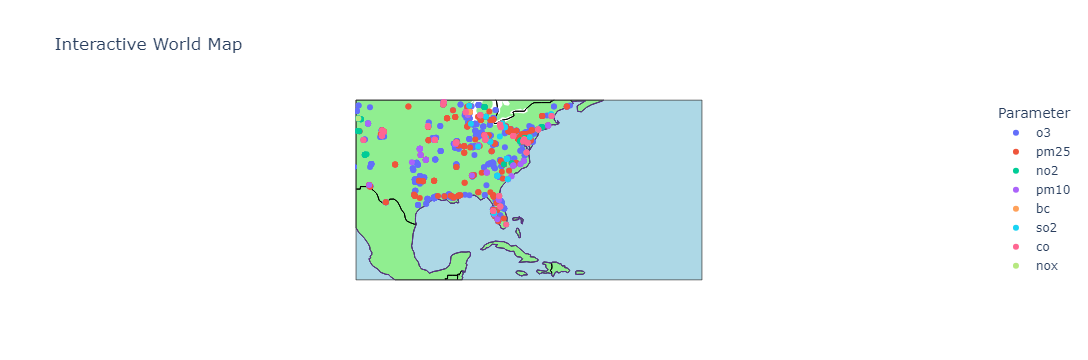

In [8]:
#We decided it would be intresting if we created an interactive world map
nn_cols = ['sensors_id', 'location_id', 'parameter', 'location', 'lon', 'lat']

# Convert Spark DataFrame to Pandas DataFrame
pandas2_df = sample_df.select(nn_cols).toPandas()

# Create the interactive world map using Plotly
fig = px.scatter_geo(pandas2_df, lat='lat', lon='lon', color='parameter', hover_name='location',
                     title='Interactive World Map',
                     labels={'parameter': 'Parameter'},
                     projection='natural earth')

# Customize the appearance of the plot (optional)
fig.update_geos(showcountries=True, countrycolor="Black", showcoastlines=True, coastlinecolor="RebeccaPurple",
                showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")

# Show the interactive world map
fig.show()

## PCA on location 1000

In [9]:
from pyspark.ml.linalg import Vectors

Re-organiziing data in dataframe to separate out parameters into their own columns

In [4]:
df.columns

['location_id',
 'sensors_id',
 'location',
 'datetime',
 'lat',
 'lon',
 'parameter',
 'units',
 'value',
 'date',
 'time']

Checking to see if the units column is redundant

In [4]:
from pyspark.sql.functions import countDistinct
# checking if the unit values are all the same for each different paramater
# Group by 'parameter' column and count distinct units
distinct_units_per_parameter = df.groupBy('parameter').agg(countDistinct('units').alias('distinct_units_count'))

# Filter out the parameters where there is more than one distinct unit
parameters_with_multiple_units = distinct_units_per_parameter.filter(distinct_units_per_parameter.distinct_units_count > 1)
parameters_with_multiple_units.show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
## checking how many distinct units there are

print(df.select('units').distinct().count())

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
spark.sql("SELECT location_id FROM pollution WHERE location = 

In [8]:
location1000_df = spark.sql("SELECT * \
                            FROM pollution \
                            WHERE location_id = 1000")

location1000_df.take(10)

[Row(location_id=1000, sensors_id=1803, location='Presque Isle Riversi-1000', datetime=datetime.datetime(2020, 1, 31, 22, 0), lat=Decimal('46.682299'), lon=Decimal('-68.016195'), parameter='pm10', units='µg/m³', value=Decimal('54.000000'), date='2020-02-01', time='06:00:00'),
 Row(location_id=1000, sensors_id=1803, location='Presque Isle Riversi-1000', datetime=datetime.datetime(2020, 1, 31, 23, 0), lat=Decimal('46.682299'), lon=Decimal('-68.016195'), parameter='pm10', units='µg/m³', value=Decimal('44.000000'), date='2020-02-01', time='07:00:00'),
 Row(location_id=1000, sensors_id=1803, location='Presque Isle Riversi-1000', datetime=datetime.datetime(2020, 2, 1, 0, 0), lat=Decimal('46.682299'), lon=Decimal('-68.016195'), parameter='pm10', units='µg/m³', value=Decimal('54.000000'), date='2020-02-01', time='08:00:00'),
 Row(location_id=1000, sensors_id=1803, location='Presque Isle Riversi-1000', datetime=datetime.datetime(2020, 2, 1, 1, 0), lat=Decimal('46.682299'), lon=Decimal('-68.0161

In [47]:
location1000_df.columns

['location_id',
 'sensors_id',
 'location',
 'datetime',
 'lat',
 'lon',
 'parameter',
 'units',
 'value',
 'date',
 'time']

In [9]:
## don't need this
parameters_location1000_df = location1000_df.groupBy('location_id', 'sensor_id', 'lat', 'lon', 'datetime').pivot('parameter').agg(avg('value'))

NameError: name 'avg' is not defined

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

location1000_parameters_df = location1000_df.groupBy("location_id", "sensors_id", "datetime").pivot("parameter").agg(F.first("value"))

In [48]:
location1000_parameters_df.columns

['location_id', 'sensors_id', 'datetime', 'pm10', 'pm25']

In [15]:
location1000_parameters_df.show()

+-----------+----------+-------------------+---------+--------+
|location_id|sensors_id|           datetime|     pm10|    pm25|
+-----------+----------+-------------------+---------+--------+
|       1000|      1803|2022-06-03 01:00:00|35.000000|    NULL|
|       1000|      1802|2016-05-29 20:00:00|     NULL|5.000000|
|       1000|      1802|2022-01-10 03:00:00|     NULL|4.000000|
|       1000|      1803|2020-03-01 04:00:00|25.000000|    NULL|
|       1000|      1802|2022-04-20 18:00:00|     NULL|2.000000|
|       1000|      1803|2019-11-24 05:00:00|14.000000|    NULL|
|       1000|      1802|2023-03-15 01:00:00|     NULL|6.200000|
|       1000|      1803|2016-09-05 01:00:00|13.000000|    NULL|
|       1000|      1803|2016-06-08 15:00:00| 9.000000|    NULL|
|       1000|      1803|2021-11-25 20:00:00|20.000000|    NULL|
|       1000|      1802|2018-12-26 07:00:00|     NULL|5.000000|
|       1000|      1803|2016-03-27 12:00:00| 3.000000|    NULL|
|       1000|      1803|2019-08-06 05:00

## Exploring this dataframe and what the data entails with missing values

In [72]:
location1000_parameters_df.describe()

ConnectionRefusedError: [Errno 111] Connection refused

Getting rid of null values

In [23]:
from pyspark.sql.types import DoubleType

for c in location1000_parameters_df.columns:
    if c not in ["location_id", "sensors_id", "datetime"]:
        pivot_df = location1000_parameters_df.withColumn(c, col(c).cast(DoubleType()))

In [24]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=[c for c in location1000_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]],
                  outputCols=[c for c in location1000_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]])
imputed_df = imputer.fit(location1000_parameters_df).transform(location1000_parameters_df)

In [25]:
imputed_df.show()

+-----------+----------+-------------------+---------+--------+
|location_id|sensors_id|           datetime|     pm10|    pm25|
+-----------+----------+-------------------+---------+--------+
|       1000|      1803|2022-06-03 01:00:00|35.000000|5.425036|
|       1000|      1802|2016-05-29 20:00:00|14.718320|5.000000|
|       1000|      1802|2022-01-10 03:00:00|14.718320|4.000000|
|       1000|      1803|2020-03-01 04:00:00|25.000000|5.425036|
|       1000|      1802|2022-04-20 18:00:00|14.718320|2.000000|
|       1000|      1803|2019-11-24 05:00:00|14.000000|5.425036|
|       1000|      1802|2023-03-15 01:00:00|14.718320|6.200000|
|       1000|      1803|2016-09-05 01:00:00|13.000000|5.425036|
|       1000|      1803|2016-06-08 15:00:00| 9.000000|5.425036|
|       1000|      1803|2021-11-25 20:00:00|20.000000|5.425036|
|       1000|      1802|2018-12-26 07:00:00|14.718320|5.000000|
|       1000|      1803|2016-03-27 12:00:00| 3.000000|5.425036|
|       1000|      1803|2019-08-06 05:00

In [41]:
parameter_columns = [c for c in location1000_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]]

In [28]:
assembler = VectorAssembler(inputCols=parameter_columns, outputCol="features")
feature_df = assembler.transform(imputed_df).select("features")

In [29]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(feature_df)
scaled_df = scaler_model.transform(feature_df)

In [31]:
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_result = pca_model.transform(scaled_df).select("pcaFeatures")

In [32]:
pca_result.show(truncate=False)

+--------------------------------------------+
|pcaFeatures                                 |
+--------------------------------------------+
|[7.162517860409107E-8,-1.264696583838334]   |
|[-0.13609308670096706,5.954628735111351E-10]|
|[-0.45628516061034324,5.954628871676757E-10]|
|[7.162517863068683E-8,-0.6411305950081203]  |
|[-1.0966693084290955,5.954629144807568E-10] |
|[7.162517865994218E-8,0.044791992705114796] |
|[0.24813740199028436,5.954628571232864E-10] |
|[7.162517866260176E-8,0.10714859158813617]  |
|[7.162517867324007E-8,0.3565749871202217]   |
|[7.162517864398472E-8,-0.32934760059301343] |
|[-0.13609308670096706,5.954628735111351E-10]|
|[7.162517868919752E-8,0.7307145804183499]   |
|[7.162517867589963E-8,0.41893158600324304]  |
|[-1.0966693084290955,5.954629144807568E-10] |
|[-0.13609308670096706,5.954628735111351E-10]|
|[0.1840989872084091,5.954628598545946E-10]  |
|[-1.4168613823384717,5.954629281372974E-10] |
|[0.8244831350271614,5.954628325415135E-10]  |
|[7.162517862

In [33]:
explained_variance = pca_model.explainedVariance
print("Explained Variance: ", explained_variance)

Explained Variance:  [0.5000000000000262,0.49999999999997374]


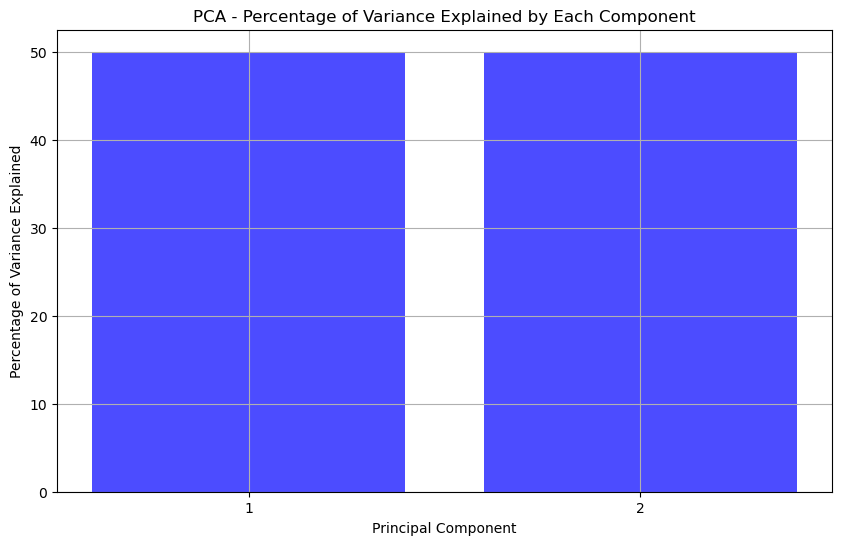

In [46]:
explained_variance_percentages = explained_variance.toArray() * 100

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_percentages) + 1), explained_variance_percentages, alpha=0.7, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('PCA - Percentage of Variance Explained by Each Component')
plt.xticks(range(1, len(explained_variance_percentages) + 1))
plt.grid(True)
plt.show()

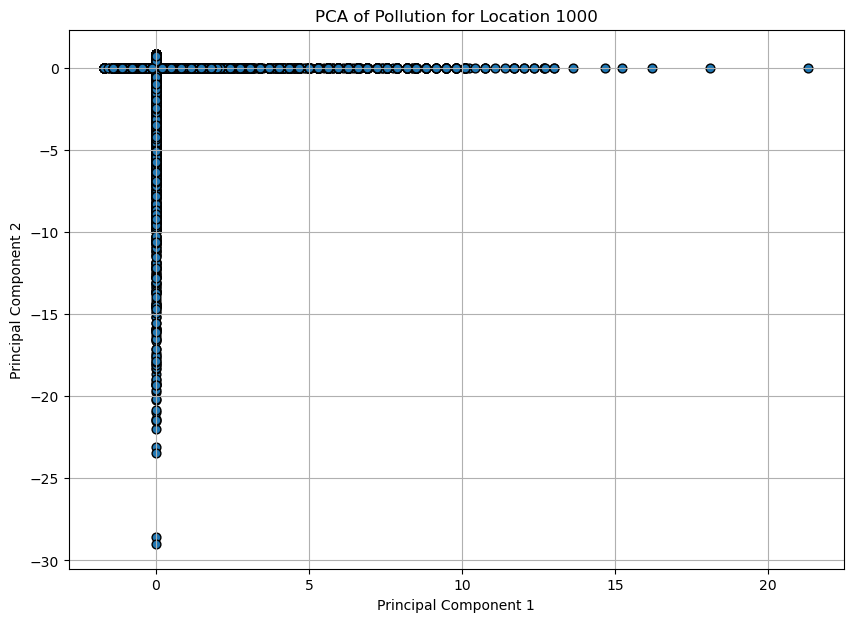

In [42]:
import numpy as np

# Transform the data
pca_result = pca_model.transform(scaled_df).select("pcaFeatures")

# Collect the PCA result to the local environment
pca_data = pca_result.collect()
# Convert to numpy array for plotting
pca_features = np.array([row['pcaFeatures'] for row in pca_data])

import matplotlib.pyplot as plt

# Extract the first and second principal components
pc1 = pca_features[:, 0]
pc2 = pca_features[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(pc1, pc2, edgecolor='k', s=40)
plt.title("PCA of Pollution for Location 1000")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## PCA on df between certain areas

## PCA on location 10233

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [8]:
location10233_df = spark.sql("SELECT * \
                            FROM pollution \
                            WHERE location_id = 10233")

location10233_df.take(10)

[Row(location_id=10233, sensors_id=33249, location='WNVLELSC-10233', datetime=datetime.datetime(2021, 3, 10, 22, 0), lat=Decimal('35.507224'), lon=Decimal('-82.963625'), parameter='o3', units='ppm', value=Decimal('0.024000'), date='2021-03-11', time='06:00:00'),
 Row(location_id=10233, sensors_id=33249, location='WNVLELSC-10233', datetime=datetime.datetime(2021, 3, 10, 23, 0), lat=Decimal('35.507224'), lon=Decimal('-82.963625'), parameter='o3', units='ppm', value=Decimal('0.023000'), date='2021-03-11', time='07:00:00'),
 Row(location_id=10233, sensors_id=33249, location='WNVLELSC-10233', datetime=datetime.datetime(2021, 3, 11, 1, 0), lat=Decimal('35.507224'), lon=Decimal('-82.963625'), parameter='o3', units='ppm', value=Decimal('0.049000'), date='2021-03-11', time='09:00:00'),
 Row(location_id=10233, sensors_id=33249, location='WNVLELSC-10233', datetime=datetime.datetime(2021, 3, 11, 2, 0), lat=Decimal('35.507224'), lon=Decimal('-82.963625'), parameter='o3', units='ppm', value=Decimal(

In [12]:
location10233_parameters_df = location10233_df.groupBy("location_id", "sensors_id", "datetime").pivot("parameter").agg(F.first("value"))

In [13]:
location10233_parameters_df.columns

['location_id', 'sensors_id', 'datetime', 'o3']

In [ ]:
imputer = Imputer(inputCols=[c for c in location10233_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]],
                  outputCols=[c for c in location10233_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]])
imputed_df = imputer.fit(location10233_parameters_df).transform(location10233_parameters_df)

In [ ]:
location10233_parameter_columns = [c for c in location10233_parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]]

In [ ]:
assembler = VectorAssembler(inputCols= location10233_parameter_columns, outputCol="features")
feature_df = assembler.transform(imputed_df).select("features")

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(feature_df)
scaled_df = scaler_model.transform(feature_df)

In [ ]:
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_result = pca_model.transform(scaled_df).select("pcaFeatures")
pca_result.show(truncate=False)

## PCA on entire dataframe

In [5]:
parameters_df = df.groupBy("location_id", "sensors_id", "datetime").pivot("parameter").agg(F.first("value"))

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [56]:
parameters_df.columns

['location_id',
 'sensors_id',
 'datetime',
 'bc',
 'co',
 'no',
 'no2',
 'nox',
 'o3',
 'pm10',
 'pm25',
 'so2']

In [65]:
parameters_df.describe()

ConnectionRefusedError: [Errno 111] Connection refused

In [66]:
imputer = Imputer(inputCols=[c for c in parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]],
                  outputCols=[c for c in parameters_df.columns if c not in ["location_id", "sensors_id", "datetime"]])
imputed_full_df = imputer.fit(parameters_df).transform(parameters_df)

ConnectionRefusedError: [Errno 111] Connection refused

## Finding location_id that have all parameters

In [71]:
required_parameters = ['bc', 'co', 'no', 'no2', 'nox', 'o3', 'pm10', 'pm25', 'so2']

location_params_df = df.select("location_id", "parameter")

# Group by location_id and collect the parameters as a list
location_with_params = location_params_df.groupBy("location_id").agg(collect_list("parameter").alias("parameters"))

# Find the first location_id that contains all required parameters
first_matching_location = location_with_params.filter(
    all(col("parameters").contains(param) for param in required_parameters)
).select("location_id").limit(1)

# Show the result
first_matching_location.show()

ConnectionRefusedError: [Errno 111] Connection refused

## AQI python package

In [74]:
pip install python-aqi

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for python-aqi: filename=python_aqi-0.6.1-py3-none-any.whl size=9649 sha256=973da787bf279df76d181b165879d4818bec908209e54455dd0d5c3a607998e8
  Stored in directory: /scratch/slin17/job_30550874/pip-ephem-wheel-cache-dhzv07gx/wheels/71/8a/aa/fba3c1469cc9480c9c0666532292f801806f1cc079ff7cdd3b
Successfully built python-aqi
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import aqi

In [28]:
myaqi = aqi.to_aqi([
    (aqi.POLLUTANT_PM25, '100'),
    (aqi.POLLUTANT_PM10, '24'),
    (aqi.POLLUTANT_O3_8H, '0.087')
])

myaqi

Decimal('174')

In [80]:
mycc = aqi.to_cc(aqi.POLLUTANT_PM25, '22', algo=aqi.ALGO_EPA)

In [ ]:
## get average value per day per station
## get average value per city?

## PCA with creating list of pm2.5 values (similar to weather example)

In [23]:
test_df = location10233_df.limit(1000)

In [29]:
test_df.show(10)

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|      date|    time|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|      10233|     33249|WNVLELSC-10233|2021-03-11 06:00:00|35.507224|-82.963625|       o3|  ppm|0.024000|2021-03-11|06:00:00|
|      10233|     33249|WNVLELSC-10233|2021-03-11 07:00:00|35.507224|-82.963625|       o3|  ppm|0.023000|2021-03-11|07:00:00|
|      10233|     33249|WNVLELSC-10233|2021-03-11 09:00:00|35.507224|-82.963625|       o3|  ppm|0.049000|2021-03-11|09:00:00|
|      10233|     33249|WNVLELSC-10233|2021-03-11 10:00:00|35.507224|-82.963625|       o3|  ppm|0.049000|2021-03-11|10:00:00|
|      10233|     33249|WNVLELSC-10233|2021-03-11 11:00:00|35.507224|-82.963625|       o3|  ppm|0.042000|2021-03-11|11

In [67]:
from pyspark.sql.functions import year, month, to_timestamp, dayofmonth, avg, first
# Filtered the DF

#location1000_pm25_df = df.filter((df.location_id == 1000) & (df.parameter == "pm2.5"))
#filtered_df = filtered_df.withColumn('datetime', to_timestamp('datetime', 'yyyy-MM-dd HH:mm:ss'))
# Add year and month columns for grouping
test_df = test_df.withColumn('year', year('datetime'))
test_df = test_df.withColumn('month', month('datetime'))
test_df = test_df.withColumn('day', dayofmonth('datetime'))
#test_df = test_df.withColumn('day', day('datetime'))
# Group by year and month, and calculate average values
result_df = test_df.groupBy('year', 'month', 'day', 'location_id').agg(
    avg('value').alias('avg_value'),
    first('sensors_id').alias('sensors_id'),
    first('location').alias('location'),
    first('lat').alias('lat'),
    first('lon').alias('lon'),
    first('parameter').alias('parameter'),
    first('units').alias('units')
).orderBy('year', 'month', 'day').cache()

# Show the result
result_df.show(100)

+----+-----+---+-----------+------------+----------+--------------+---------+----------+---------+-----+
|year|month|day|location_id|   avg_value|sensors_id|      location|      lat|       lon|parameter|units|
+----+-----+---+-----------+------------+----------+--------------+---------+----------+---------+-----+
|2019|   10|  2|      10233|0.0271875000|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2019|   10|  3|      10233|0.0060000000|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2019|   10|  9|      10233|0.0178333333|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2019|   10| 10|      10233|0.0052000000|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2019|   10| 26|      10233|0.0231176471|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2019|   10| 27|      10233|0.0198000000|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|
|2020|    3|  9|      10233|0.0378333333|     33249|WNV

In [80]:
from pyspark.sql.functions import collect_list

listed_df = result_df.groupBy("location_id", "sensors_id", "location", "lat", "lon", "parameter", "units")\
    .agg(collect_list("avg_value").alias("avg_values"))

listed_df.show(truncate = True)

+-----------+----------+--------------+---------+----------+---------+-----+--------------------+
|location_id|sensors_id|      location|      lat|       lon|parameter|units|          avg_values|
+-----------+----------+--------------+---------+----------+---------+-----+--------------------+
|      10233|     33249|WNVLELSC-10233|35.507224|-82.963625|       o3|  ppm|[0.0271875000, 0....|
+-----------+----------+--------------+---------+----------+---------+-----+--------------------+



In [74]:
## Test on new location_id with more consistent data
## Run PCA


## how many weeks of the year is pollution above a certain amount

DataFrame[location_id: int, avg_values: array<decimal(14,10)>]

In [55]:
daily_avg_data.show(100)

+----+-----+---+------------+
|year|month|day|   avg_value|
+----+-----+---+------------+
|2019|   10|  2|0.0271875000|
|2019|   10|  3|0.0060000000|
|2019|   10|  9|0.0178333333|
|2019|   10| 10|0.0052000000|
|2019|   10| 26|0.0231176471|
|2019|   10| 27|0.0198000000|
|2020|    3|  9|0.0378333333|
|2020|    3| 10|0.0462000000|
|2020|    3| 12|0.0184444444|
|2020|    3| 13|0.0336521739|
|2020|    3| 14|0.0260000000|
|2020|    3| 15|0.0274444444|
|2020|    3| 16|0.0170000000|
|2020|    3| 18|0.0207777778|
|2020|    3| 19|0.0348000000|
|2020|    3| 21|0.0288235294|
|2020|    3| 22|0.0270000000|
|2020|    3| 26|0.0285000000|
|2020|    3| 27|0.0464000000|
|2020|    4| 28|0.0282941176|
|2020|    4| 29|0.0584000000|
|2020|    5|  6|0.0380625000|
|2020|    5|  7|0.0386000000|
|2020|    5| 28|0.0360000000|
|2020|    5| 29|0.0262000000|
|2020|    6|  8|0.0306000000|
|2020|    6|  9|0.0152000000|
|2020|    7| 28|0.0154000000|
|2020|    9| 12|0.0106666667|
|2020|    9| 13|0.0038000000|
|2020|    

In [42]:
daily_avg_data.count()

99

In [ ]:
## For later
pm25_df = df.filter(df.parameter == "pm25")

# Group by location_id and collect pm2.5 values into a list
result_df = pm25_df.groupBy("location_id") \
    .agg(F.collect_list("value").alias("pm2.5 values"))

# Show the result
result_df.show(truncate=False)

## PCA on most polluted areas

Tranforming data into 1-d array of values

In [12]:
most_polluted_df = spark.sql("SELECT * \
                    FROM pollution \
                    WHERE (parameter = 'pm10' AND value > 150) OR (parameter = 'pm25' AND value > 12) OR (parameter = 'o3' AND value > 0.07)")

In [13]:
from pyspark.sql.functions import year, month, to_timestamp, dayofmonth, avg, first
# Filtered the DF

#location1000_pm25_df = df.filter((df.location_id == 1000) & (df.parameter == "pm2.5"))
#filtered_df = filtered_df.withColumn('datetime', to_timestamp('datetime', 'yyyy-MM-dd HH:mm:ss'))
# Add year and month columns for grouping
most_polluted_df = most_polluted_df.withColumn('year', year('datetime'))
most_polluted_df = most_polluted_df.withColumn('month', month('datetime'))
#most_polluted_df = most_polluted_df.withColumn('day', dayofmonth('datetime'))
#test_df = test_df.withColumn('day', day('datetime'))
# Group by year and month, and calculate average values
avg_most_polluted_df = most_polluted_df.groupBy('year', 'month','location_id').agg(
    avg('value').alias('avg_value'),
    first('sensors_id').alias('sensors_id'),
    first('location').alias('location'),
    first('lat').alias('lat'),
    first('lon').alias('lon'),
    first('parameter').alias('parameter'),
    first('units').alias('units')
).orderBy('year', 'month').cache()

In [14]:
from pyspark.sql.functions import collect_list

listed_most_polluted_df = avg_most_polluted_df.groupBy("location_id", "sensors_id", "location", "lat", "lon", "parameter", "units")\
    .agg(collect_list("avg_value").alias("avg_values"))

listed_most_polluted_df.show(truncate = True)

+-----------+----------+--------------------+---------+-----------+---------+-----+--------------------+
|location_id|sensors_id|            location|      lat|        lon|parameter|units|          avg_values|
+-----------+----------+--------------------+---------+-----------+---------+-----+--------------------+
|       1000|      1802|Presque Isle Rive...|46.682299| -68.016195|     pm25|µg/m³|[30.0000000000, 1...|
|       1000|      1803|Presque Isle Rive...|46.682299| -68.016195|     pm10|µg/m³|[69.3636363636, 1...|
|       1001|      1804|       PURCHASE-1001|35.587200| -83.075300|       o3|  ppm|[0.0732000000, 0....|
|       1002|      1805|        Pacific-1002|38.490200| -90.705200|       o3|  ppm|[0.0720000000, 0....|
|       1003|      1807|        Padonia-1003|39.462002| -76.631599|     pm25|µg/m³|[15.9335694444, 1...|
|       1005|      1810|     Paia, Maui-1005|20.902031|-156.370344|     pm25|µg/m³|[17.2941176471, 1...|
|       1006|      1811|    Painesville-1006|41.726811|

Selecting just the o3 values

In [21]:
avg_most_polluted_df.show()

+----+-----+-----------+--------------+----------+--------------------+---------+-----------+---------+-----+
|year|month|location_id|     avg_value|sensors_id|            location|      lat|        lon|parameter|units|
+----+-----+-----------+--------------+----------+--------------------+---------+-----------+---------+-----+
|2014|    1|      11567| 15.2551724138|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014|    2|      11567| 18.8250000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014|    3|      11567| 20.5142857143|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014|    6|      11569| 25.6121212121|     39286|SPARTAN - Mammoth...|37.132000| -86.148000|     pm25|µg/m³|
|2014|    7|      11569| 18.4584905660|     39286|SPARTAN - Mammoth...|37.132000| -86.148000|     pm25|µg/m³|
|2014|    8|      11569| 19.8048780488|     39286|SPARTAN - Mammoth...|37.132000| -86.148000|     pm25|µg/m³|
|2016|    

In [34]:
avg_most_polluted_df.filter(avg_most_polluted_df.parameter == 'pm25').count()

15010

pm 2.5 parameter has the most entries

In [35]:
filtered_mostpolluted_df = avg_most_polluted_df.filter\
((avg_most_polluted_df.parameter == 'pm25') & (avg_most_polluted_df.year > 2016) & (avg_most_polluted_df.year < 2022))

filtered_mostpolluted_df.show()

+----+-----+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|year|month|location_id|    avg_value|sensors_id|            location|      lat|        lon|parameter|units|
+----+-----+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|2017|    1|       1026|16.5238095238|      1851|     Pearl City-1026|21.392834|-157.969131|     pm25|µg/m³|
|2017|    1|       1040|15.6410256410|      1874|      Piney Run-1040|39.705799| -79.011902|     pm25|µg/m³|
|2017|    1|       1048|20.1645669291|      1882|Plummer CDA Tribe...|47.338600|-116.885902|     pm25|µg/m³|
|2017|    1|       1053|14.7463414634|      1890|     Ponca City-1053|36.697189| -97.081278|     pm25|µg/m³|
|2017|    1|       1079|16.8837209302|      1932|    2912 Coffey-1079|41.133317| -95.956078|     pm25|µg/m³|
|2017|    1|       1081|18.4156626506|      1934|     Hagerstown-1081|39.565601| -77.721901|     pm25|µg/m³|
|2017|    1|       

Transforming into 1-d array of values per station

In [37]:
listed_mostpolluted_df = filtered_mostpolluted_df.groupBy("location_id", "sensors_id", "location", "lat", "lon", "parameter", "units")\
    .agg(collect_list("avg_value").alias("avg_values"))

listed_mostpolluted_df.show(truncate = True)

+-----------+----------+--------------------+---------+-----------+---------+-----+--------------------+
|location_id|sensors_id|            location|      lat|        lon|parameter|units|          avg_values|
+-----------+----------+--------------------+---------+-----------+---------+-----+--------------------+
|       1000|      1802|Presque Isle Rive...|46.682299| -68.016195|     pm25|µg/m³|[37.8169934641, 2...|
|       1003|      1807|        Padonia-1003|39.462002| -76.631599|     pm25|µg/m³|[16.9549549550, 1...|
|       1005|      1810|     Paia, Maui-1005|20.902031|-156.370344|     pm25|µg/m³|[15.5735294118, 1...|
|       1006|      1813|    Painesville-1006|41.726811| -81.242156|     pm25|µg/m³|[14.5673076923, 1...|
|       1010|      1819|   Preble NCore-1010|39.835620| -84.720490|     pm25|µg/m³|[15.6963855422, 1...|
|       1012|      1824|         Palmer-1012|61.598900|-149.106216|     pm25|µg/m³|[17.0731707317, 2...|
|       1013|     22437|     Palo Verde-1013|36.173415|

Applying PCA

In [76]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

convert_to_double_udf = udf(lambda x: [float(i) for i in x], ArrayType(DoubleType()))

# Apply the UDF to convert pm25_values to array<double>
listed_mostpolluted_df = listed_mostpolluted_df.withColumn("avg_values", convert_to_double_udf(col("avg_values")))


num_elements = len(listed_mostpolluted_df.select("avg_values").first()[0])
for i in range(num_elements):
    listed_mostpolluted_df = listed_mostpolluted_df.withColumn(f"pm25_{i}", col("avg_values")[i])

listed_mostpolluted_df = listed_mostpolluted_df.na.drop(subset=[f"pm25_{i}" for i in range(num_elements)])

# List of new columns created
new_columns = [f"pm25_{i}" for i in range(num_elements)]

assembler = VectorAssembler(inputCols=new_columns, outputCol="features")
feature_df = assembler.transform(listed_mostpolluted_df).select("location_id", "features")

# Standardize the feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(feature_df)
scaled_df = scaler_model.transform(feature_df)

# Apply PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_result = pca_model.transform(scaled_df).select("location_id", "pcaFeatures")

# Show the result
pca_result.show(truncate= False)

+-----------+------------------------------------------+
|location_id|pcaFeatures                               |
+-----------+------------------------------------------+
|1000       |[-4.76771455754802,-16.017860088913732]   |
|1006       |[3.561255851634033,0.6732176623531428]    |
|1010       |[1.3251778539304733,0.18566816796217697]  |
|1026       |[-1.03598213574036,1.0352225546663385]    |
|1031       |[-0.7623968739022926,-0.15679715101627117]|
|1040       |[2.9825205807811317,0.8335658379559302]   |
|1048       |[-2.5884804625515976,-1.509213726167148]  |
|1053       |[0.2700337933128651,0.894267209616457]    |
|1070       |[0.6573770200515572,0.2870553778381628]   |
|1079       |[-0.04295361710024343,0.6370247616555014] |
|1081       |[0.612380028050248,1.3947568928164469]    |
|1083       |[1.7713112161104834,-0.6674228107324824]  |
|1096       |[0.9362394190267725,0.025110447489104]    |
|1102       |[0.8643181277444478,0.6613545546642021]   |
|1112       |[2.155160015033082

In [58]:
explained_variance = pca_model.explainedVariance
print("Explained Variance: ", explained_variance)

Explained Variance:  [0.23435387429938825,0.08399646001651351,0.06124706547233708,0.05421375009643578,0.05048295821773119,0.04481951958593088,0.04048540684780373,0.038190673421988,0.03489291940158464,0.029849274714564188]


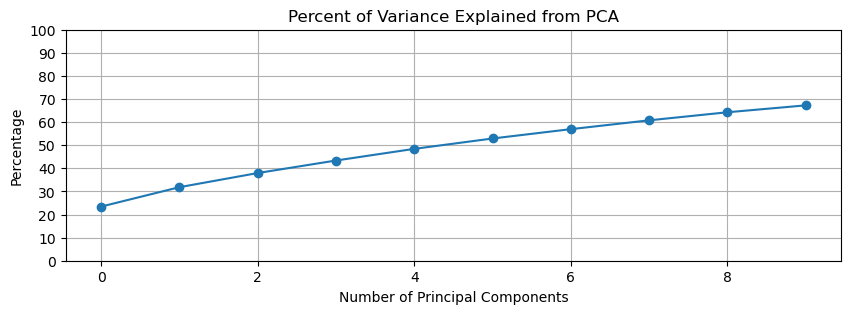

In [75]:
import numpy as np
import matplotlib.pyplot as plt

explained_variance = pca_model.explainedVariance.toArray()

cumulative_variance = np.cumsum(explained_variance)
x_axis = range(0, len(cumulative_variance))

plt.figure(figsize=(10, 3))
plt.plot(x_axis, cumulative_variance * 100, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage')
plt.title('Percent of Variance Explained from PCA')
plt.yticks(np.arange(0, 101, step=10))
plt.grid(True)
plt.show()

In [84]:
df.columns

['location_id',
 'sensors_id',
 'location',
 'datetime',
 'lat',
 'lon',
 'parameter',
 'units',
 'value',
 'date',
 'time']

## Finding location_id with o3, pm25, pm10 parameters values present. Testing on small batch

In [89]:
from pyspark.sql.functions import col, collect_set, array_contains, size

parameter_df = most_polluted_df.groupBy("location_id").agg(collect_set("parameter").alias("parameters"))

locations_with_all_parameters = parameter_df.filter(
    array_contains(col("parameters"), "o3") & 
    array_contains(col("parameters"), "pm25") & 
    array_contains(col("parameters"), "pm10")
).select("location_id")

filtered_df = most_polluted_df.join(locations_with_all_parameters, "location_id")

filtered_df.show(truncate=False)

+-----------+----------+-----------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|location_id|sensors_id|location         |datetime           |lat      |lon       |parameter|units|value    |date      |time    |year|month|
+-----------+----------+-----------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|1473       |2606      |WATSON-1473      |2017-12-30 04:00:00|38.060800|-85.896100|pm25     |µg/m³|24.800000|2017-12-30|04:00:00|2017|12   |
|1473       |2606      |WATSON-1473      |2017-12-05 05:00:00|38.060800|-85.896100|pm25     |µg/m³|15.200000|2017-12-05|05:00:00|2017|12   |
|1473       |2606      |WATSON-1473      |2021-07-18 03:00:00|38.060800|-85.896100|pm25     |µg/m³|12.800000|2021-07-18|03:00:00|2021|7    |
|1341       |2412      |Lawton North-1341|2018-06-02 06:00:00|34.632999|-98.428802|pm25     |µg/m³|16.100000|2018-06-02|06:00:00|2018|6    |
|1341       |

In [91]:
test_parameter_df = filtered_df.groupBy("location_id").agg(collect_set("parameter").alias("parameters"))
test_parameter_df.show(500)

+-----------+----------------+
|location_id|      parameters|
+-----------+----------------+
|      12027|[pm10, pm25, o3]|
|       1226|[pm10, pm25, o3]|
|       1537|[pm10, pm25, o3]|
|       1265|[pm10, pm25, o3]|
|       1473|[pm10, pm25, o3]|
|       1155|[pm10, pm25, o3]|
|       1302|[pm10, pm25, o3]|
|       1290|[pm10, pm25, o3]|
|       1341|[pm10, pm25, o3]|
|       1541|[pm10, pm25, o3]|
|       1455|[pm10, pm25, o3]|
|       1467|[pm10, pm25, o3]|
|       1186|[pm10, pm25, o3]|
|       1169|[pm10, pm25, o3]|
|       1310|[pm10, pm25, o3]|
|       1121|[pm10, pm25, o3]|
|       1164|[pm10, pm25, o3]|
|       1022|[pm10, pm25, o3]|
|       1132|[pm10, pm25, o3]|
|       1540|[pm10, pm25, o3]|
|       1124|[pm10, pm25, o3]|
|       1091|[pm10, pm25, o3]|
|      12028|[pm10, pm25, o3]|
|       1161|[pm10, pm25, o3]|
|       1297|[pm10, pm25, o3]|
|       1459|[pm10, pm25, o3]|
|       1200|[pm10, pm25, o3]|
|       1305|[pm10, pm25, o3]|
|       1196|[pm10, pm25, o3]|
|       

## Finding location_id with all three parameters present in entire df

Selecting locations with parameters of o3, pm25, pm10 present

In [7]:
from pyspark.sql.functions import col, collect_set, array_contains, size

parameter_df = df.groupBy("location_id").agg(collect_set("parameter").alias("parameters"))

locations_with_all_parameters = parameter_df.filter(
    array_contains(col("parameters"), "o3") & 
    array_contains(col("parameters"), "pm25") & 
    array_contains(col("parameters"), "pm10")
).select("location_id")

filtered_df = df.join(locations_with_all_parameters, "location_id").cache()

filtered_df.show(truncate=False)

+-----------+----------+------------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|location          |datetime           |lat      |lon       |parameter|units|value   |date      |time    |
+-----------+----------+------------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|1132       |24301     |Gwinnett Tech-1132|2020-05-20 15:00:00|33.963600|-84.066400|pm10     |µg/m³|2.000000|2020-05-20|15:00:00|
|1132       |2032      |Gwinnett Tech-1132|2020-05-20 15:00:00|33.963600|-84.066400|pm25     |µg/m³|1.500000|2020-05-20|15:00:00|
|1132       |2035      |Gwinnett Tech-1132|2020-05-20 05:00:00|33.963600|-84.066400|o3       |ppm  |0.019000|2020-05-20|05:00:00|
|1132       |2035      |Gwinnett Tech-1132|2020-05-20 06:00:00|33.963600|-84.066400|o3       |ppm  |0.019000|2020-05-20|06:00:00|
|1132       |2035      |Gwinnett Tech-1132|2020-05-20 07:00:00|33.963600|-84.066400|o3    

In [21]:
test_parameter_df = filtered_df.groupBy("location_id").agg(collect_set("parameter").alias("parameters"))
test_parameter_df.show(500)

+-----------+--------------------+
|location_id|          parameters|
+-----------+--------------------+
|      12027|    [pm10, pm25, o3]|
|       1265|[no2, pm10, so2, ...|
|       1537|    [pm10, pm25, o3]|
|       1226|[no2, pm10, so2, ...|
|       1290|    [pm10, pm25, o3]|
|       1512|    [pm10, pm25, o3]|
|       1302|[no2, pm10, pm25,...|
|       1473|[pm10, so2, pm25,...|
|       1155|    [pm10, pm25, o3]|
|       1455|    [pm10, pm25, o3]|
|       1467|[no2, pm10, pm25,...|
|       1113|[no2, pm10, so2, ...|
|       1341|    [pm10, pm25, o3]|
|       1541|    [pm10, pm25, o3]|
|       1186|    [pm10, pm25, o3]|
|       1490|[pm10, so2, pm25,...|
|       1559|[no2, pm10, so2, ...|
|       1151|    [pm10, pm25, o3]|
|       1132|    [pm10, pm25, o3]|
|       1091|[no2, pm10, co, p...|
|      12028|    [pm10, pm25, o3]|
|       1310|    [pm10, pm25, o3]|
|       1248|    [pm10, pm25, o3]|
|       1124|[no2, pm10, pm25,...|
|       1164|    [pm10, pm25, o3]|
|       1121|[no2, p

Finding average value per day

In [109]:
from pyspark.sql.functions import year, month, to_timestamp, dayofmonth, avg, first

# Group by year and month, and calculate average values
dailyavg_df = filtered_df.groupBy('date', 'location_id').agg(
    avg('value').alias('avg_value'),
    first('sensors_id').alias('sensors_id'),
    first('location').alias('location'),
    first('lat').alias('lat'),
    first('lon').alias('lon'),
    first('parameter').alias('parameter'),
    first('units').alias('units')
).orderBy('date','location_id')

# Show the result
dailyavg_df.show(100)

+----------+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|      date|location_id|    avg_value|sensors_id|            location|      lat|        lon|parameter|units|
+----------+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|2014-01-18|      11567| 4.5700000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-19|      11567| 5.3750000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-20|      11567| 6.1000000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-21|      11567| 6.1166666667|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-22|      11567| 5.3916666667|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-23|      11567| 7.2875000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-24|      1

Splitting up parameters into different columns

In [111]:
from pyspark.sql import functions as F

sep_param_df = dailyavg_df.\
    groupBy("location_id", "sensors_id", "location","lat", "lon","units","date").\
    pivot("parameter").agg(F.first("avg_value"))

sep_param_df = sep_param_df.drop('co', 'no', 'no2', 'nox', 'so2', 'bc')

# getting rid of timepoints with 0 for o3, pm25, and pm10 values. 

sep_param_df = sep_param_df.filter(~((F.col("o3") == 0) & (F.col("pm10") == 0) & (F.col("pm25") == 0)))

sep_param_df.show()

+-----------+----------+--------------------+---------+----------+-----+----------+----+----+-------------+
|location_id|sensors_id|            location|      lat|       lon|units|      date|  o3|pm10|         pm25|
+-----------+----------+--------------------+---------+----------+-----+----------+----+----+-------------+
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-18|NULL|NULL| 4.5700000000|
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-19|NULL|NULL| 5.3750000000|
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-20|NULL|NULL| 6.1000000000|
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-21|NULL|NULL| 6.1166666667|
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-22|NULL|NULL| 5.3916666667|
|      11567|     39284|SPARTAN - Emory U...|33.688000|-84.290000|µg/m³|2014-01-23|NULL|NULL| 7.2875000000|
|      11567|     39284|SPAR

Adding column to dataframe that calculates AQI value based on pollutants available for each time point

In [112]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

## creating function to convert between pollutant values and AQI using AQI library function
def calculate_aqi(o3, pm10, pm25):
    try:
        pollutants = []
        if o3 is not None and o3 != 0:
            pollutants.append((aqi.POLLUTANT_O3_8H, str(o3)))
        if pm10 is not None and pm10 != 0:
            pollutants.append((aqi.POLLUTANT_PM10, str(pm10)))
        if pm25 is not None and pm25 != 0:
            pollutants.append((aqi.POLLUTANT_PM25, str(pm25)))
        return float(aqi.to_aqi(pollutants))
    except Exception as e:
        return None
calculate_aqi_udf = udf(calculate_aqi, FloatType())

# Apply UDF to create a new column 'AQI score'
aqi_df= sep_param_df.withColumn("AQI_score", calculate_aqi_udf(F.col("o3"), F.col("pm10"), F.col("pm25")))

aqi_df.show(truncate=False)
        

+-----------+----------+--------------------------------+---------+----------+-----+----------+----+----+-------------+---------+
|location_id|sensors_id|location                        |lat      |lon       |units|date      |o3  |pm10|pm25         |AQI_score|
+-----------+----------+--------------------------------+---------+----------+-----+----------+----+----+-------------+---------+
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-18|NULL|NULL|4.5700000000 |19.0     |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-19|NULL|NULL|5.3750000000 |22.0     |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-20|NULL|NULL|6.1000000000 |25.0     |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-21|NULL|NULL|6.1166666667 |25.0     |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-0

In [113]:
aqi_df.filter(F.col("AQI_score").isNull()).count()

3913

Adding column to converts from aqi score to aqi category based on pre-defined thresholds from internet

In [114]:
from pyspark.sql.types import StringType
import aqi

def aqi_threshold(aqi_score):
    if aqi_score is None:
        return None
    if aqi_score <= 50:
        return "Good"
    if aqi_score <= 100:
        return "Moderate"
    if aqi_score <= 150:
        return "Unhealthy for sensitive groups"
    if aqi_score <= 200:
        return "Unhealthy"
    if aqi_score <= 300:
        return "Very unhealthy"
    else:
        return "Hazardous"

calculate_aqi_threshold = udf(aqi_threshold, StringType())

aqi_category_df= aqi_df.withColumn("AQI_category", calculate_aqi_threshold(F.col("AQI_score")))

aqi_category_df.show(truncate=False)

+-----------+----------+--------------------------------+---------+----------+-----+----------+----+----+-------------+---------+------------+
|location_id|sensors_id|location                        |lat      |lon       |units|date      |o3  |pm10|pm25         |AQI_score|AQI_category|
+-----------+----------+--------------------------------+---------+----------+-----+----------+----+----+-------------+---------+------------+
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-18|NULL|NULL|4.5700000000 |19.0     |Good        |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-19|NULL|NULL|5.3750000000 |22.0     |Good        |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-20|NULL|NULL|6.1000000000 |25.0     |Good        |
|11567      |39284     |SPARTAN - Emory University-11567|33.688000|-84.290000|µg/m³|2014-01-21|NULL|NULL|6.1166666667 |25.0     |Good        |

For each location_id, finding counts of how many timepoints are good, moderate, unhealthy, etc

In [115]:
# Grouping by location_id and counting the number of daily good, moderate, etc categories
grouped_df = aqi_category_df.groupBy("location_id", "AQI_category").count()

category_counts_df = grouped_df.groupBy("location_id").pivot("AQI_category").sum("count")

category_counts_df = category_counts_df.fillna(0)

category_counts_df.show(truncate=False)

+-----------+----+----+---------+--------+---------+------------------------------+--------------+
|location_id|null|Good|Hazardous|Moderate|Unhealthy|Unhealthy for sensitive groups|Very unhealthy|
+-----------+----+----+---------+--------+---------+------------------------------+--------------+
|1342       |9   |2108|0        |24      |0        |1                             |0             |
|1088       |8   |2032|0        |3       |0        |0                             |0             |
|12027      |0   |487 |0        |2       |0        |0                             |0             |
|1507       |0   |415 |0        |1       |0        |0                             |0             |
|1522       |0   |2139|0        |6       |0        |0                             |0             |
|1395       |0   |1560|0        |144     |16       |9                             |0             |
|1025       |0   |284 |0        |1       |0        |0                             |0             |
|1322     

In [79]:
category_counts_df.count()

50

In [71]:
aqi_category_df.count()

93081

In [77]:
df.select('location_id').distinct().count()

520

## Time series data for pm2.5

Getting parquet file into dataframe

In [ ]:
# This will grab the data someone in the group has already downloaded. 
path = "/expanse/lustre/projects/uci150/cmerry/data/records/csv.gz/country=us"  

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DecimalType

schema = StructType([
    StructField("location_id", IntegerType(), True),
    StructField("sensors_id", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("datetime", TimestampType(), True),
    StructField("lat", DecimalType(precision=10, scale=6), True),
    StructField("lon", DecimalType(precision=10, scale=6), True),
    StructField("parameter", StringType(), True),
    StructField("units", StringType(), True),
    StructField("value", DecimalType(precision=10, scale=6), True),
])


# Read CSV files matching the pattern into a DataFrame
#df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(path)
df = spark.read.option("recursiveFileLookup", "true").csv(path, header=True, schema=schema)

In [101]:
parameters_df = df.groupBy("location_id").agg(collect_set("parameter").alias("parameters"))

locations_with_all_parameters = parameter_df.filter(
    array_contains(col("parameters"), "pm25") 
).select("location_id")

pm25_df = df.join(locations_with_all_parameters, "location_id").cache()

pm25_df.show(truncate=False)

+-----------+----------+------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+
|location_id|sensors_id|location          |datetime           |lat      |lon       |parameter|units|value    |date      |time    |
+-----------+----------+------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+
|1451       |25973     |Warner Robins-1451|2019-04-18 20:00:00|32.605600|-83.597900|pm10     |µg/m³|19.000000|2019-04-18|20:00:00|
|1451       |25973     |Warner Robins-1451|2019-04-18 21:00:00|32.605600|-83.597900|pm10     |µg/m³|17.000000|2019-04-18|21:00:00|
|1451       |25973     |Warner Robins-1451|2019-04-18 22:00:00|32.605600|-83.597900|pm10     |µg/m³|20.000000|2019-04-18|22:00:00|
|1451       |25973     |Warner Robins-1451|2019-04-19 00:00:00|32.605600|-83.597900|pm10     |µg/m³|22.000000|2019-04-19|00:00:00|
|1451       |25973     |Warner Robins-1451|2019-04-19 01:00:00|32.605600|-83.597900

In [108]:
#pm25_df = pm25_df.withColumn('year', year('datetime'))
#pm25_df = pm25_df.withColumn('month', month('datetime'))
#pm25_df = pm25_df.withColumn('day', dayofmonth('datetime'))

# Group by year and month, and calculate average values
pm25_dailyavg_df = pm25_df.groupBy('date', 'location_id').agg(
    avg('value').alias('avg_value'),
    first('sensors_id').alias('sensors_id'),
    first('location').alias('location'),
    first('lat').alias('lat'),
    first('lon').alias('lon'),
    first('parameter').alias('parameter'),
    first('units').alias('units'),
).orderBy('date','location_id')

# Show the result
pm25_dailyavg_df.show(100)

+----------+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|      date|location_id|    avg_value|sensors_id|            location|      lat|        lon|parameter|units|
+----------+-----------+-------------+----------+--------------------+---------+-----------+---------+-----+
|2014-01-18|      11567| 4.5700000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-19|      11567| 5.3750000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-20|      11567| 6.1000000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-21|      11567| 6.1166666667|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-22|      11567| 5.3916666667|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-23|      11567| 7.2875000000|     39284|SPARTAN - Emory U...|33.688000| -84.290000|     pm25|µg/m³|
|2014-01-24|      1

In [122]:
US_pm25_dailyavg = pm25_dailyavg_df.groupBy('date').agg(avg('avg_value').alias('avg_value'))
US_pm25_dailyavg.show()

+----------+----------------+
|      date|       avg_value|
+----------+----------------+
|2016-08-17|4.81241835980121|
|2020-04-13|4.83954441351263|
|2020-02-26|5.24631027909254|
|2019-08-08|5.58286059805072|
|2017-12-05|7.33984552337778|
|2019-08-22|4.82207398855049|
|2017-05-14|4.65855572850441|
|2021-11-03|6.37784035937172|
|2022-10-05|6.87626210720308|
|2019-08-23|4.54120385254780|
|2023-01-21|6.25309964021918|
|2016-08-08|4.61628844689920|
|2016-04-22|5.30241433010797|
|2021-12-23|6.77097610807333|
|2016-08-20|4.87945422254297|
|2017-10-20|6.97966011603070|
|2017-05-11|5.90937507691280|
|2018-12-31|5.81216908427946|
|2022-10-07|7.43403588866884|
|2020-06-24|4.28710840950303|
+----------+----------------+
only showing top 20 rows



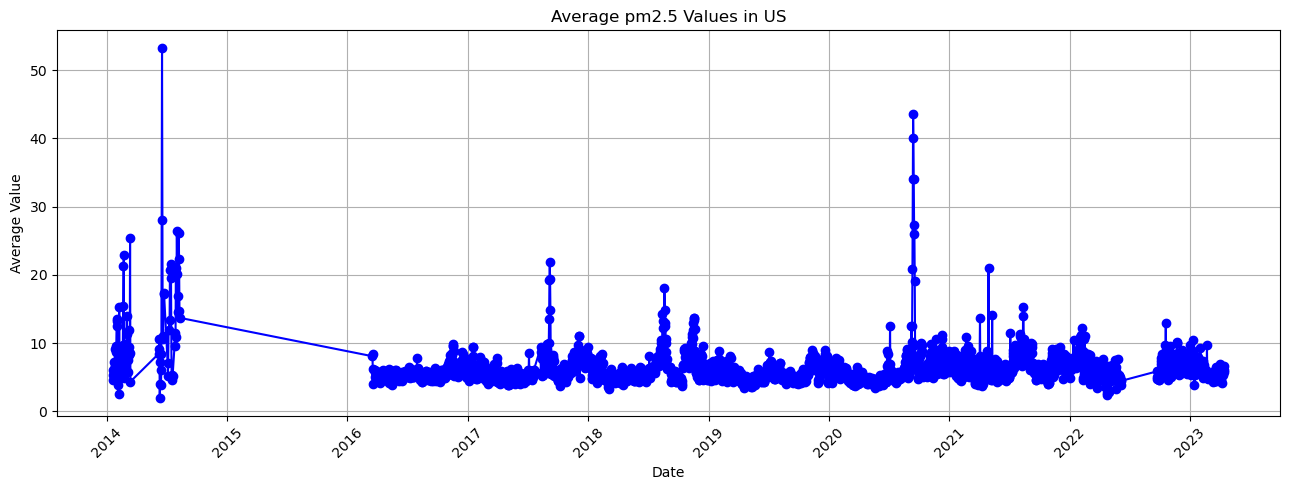

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

USpm25_pandas = US_pm25_dailyavg.toPandas()

# Convert date column to datetime format
USpm25_pandas['date'] = pd.to_datetime(USpm25_pandas['date'])

# Sort the data by date
USpm25_pandas = USpm25_pandas.sort_values('date')

# Plotting
plt.figure(figsize=(13, 5))
plt.plot(USpm25_pandas['date'], USpm25_pandas['avg_value'], marker='o', linestyle='-', color='b')
plt.title('Average pm2.5 Values in US')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [134]:
max_row = US_pm25_dailyavg.orderBy(col("avg_value").desc()).first()
max_date = max_row['date']
max_value = max_row['avg_value']

max_date

'2014-06-17'

In [149]:
USpm25_pandas['avg_value'].isnull().sum()

0

In [155]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import unix_timestamp, to_date, col

# Convert date to timestamp and add a debug print
US_pm25_dailyavg = US_pm25_dailyavg.withColumn('date_parsed', to_date(col('date'), 'yyyy-MM-dd'))
US_pm25_dailyavg = US_pm25_dailyavg.withColumn('timestamp', unix_timestamp(col('date_parsed')))

# Show the DataFrame to debug
US_pm25_dailyavg.show(truncate=False)

# Separate training and test sets
train_df = US_pm25_dailyavg.filter(col('date_parsed') < '2022-01-01')
test_df = US_pm25_dailyavg.filter(col('date_parsed') >= '2022-01-01')

# Show the training and test sets
print("Training Data:")
train_df.show(truncate=False)
print("Test Data:")
test_df.show(truncate=False)

+----------+----------------+----------+-----------+
|date      |avg_value       |timestamp |date_parsed|
+----------+----------------+----------+-----------+
|2016-08-17|4.81241835980121|1471392000|2016-08-17 |
|2020-04-13|4.83954441351263|1586736000|2020-04-13 |
|2020-02-26|5.24631027909254|1582675200|2020-02-26 |
|2019-08-08|5.58286059805072|1565222400|2019-08-08 |
|2017-12-05|7.33984552337778|1512432000|2017-12-05 |
|2019-08-22|4.82207398855049|1566432000|2019-08-22 |
|2017-05-14|4.65855572850441|1494720000|2017-05-14 |
|2021-11-03|6.37784035937172|1635897600|2021-11-03 |
|2022-10-05|6.87626210720308|1664928000|2022-10-05 |
|2019-08-23|4.54120385254780|1566518400|2019-08-23 |
|2023-01-21|6.25309964021918|1674259200|2023-01-21 |
|2016-08-08|4.61628844689920|1470614400|2016-08-08 |
|2016-04-22|5.30241433010797|1461283200|2016-04-22 |
|2021-12-23|6.77097610807333|1640217600|2021-12-23 |
|2016-08-20|4.87945422254297|1471651200|2016-08-20 |
|2017-10-20|6.97966011603070|1508457600|2017-1

In [157]:
# Create feature vectors with handleInvalid option
assembler = VectorAssembler(inputCols=['timestamp'], outputCol='features', handleInvalid='skip')
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Debug print of assembled features
print("Training Data with Features:")
train_df.show(truncate=False)
print("Test Data with Features:")
test_df.show(truncate=False)

Training Data with Features:
+----------+----------------+----------+-----------+-------------+
|date      |avg_value       |timestamp |date_parsed|features     |
+----------+----------------+----------+-----------+-------------+
|2016-08-17|4.81241835980121|1471392000|2016-08-17 |[1.471392E9] |
|2020-04-13|4.83954441351263|1586736000|2020-04-13 |[1.586736E9] |
|2020-02-26|5.24631027909254|1582675200|2020-02-26 |[1.5826752E9]|
|2019-08-08|5.58286059805072|1565222400|2019-08-08 |[1.5652224E9]|
|2017-12-05|7.33984552337778|1512432000|2017-12-05 |[1.512432E9] |
|2019-08-22|4.82207398855049|1566432000|2019-08-22 |[1.566432E9] |
|2017-05-14|4.65855572850441|1494720000|2017-05-14 |[1.49472E9]  |
|2021-11-03|6.37784035937172|1635897600|2021-11-03 |[1.6358976E9]|
|2019-08-23|4.54120385254780|1566518400|2019-08-23 |[1.5665184E9]|
|2016-08-08|4.61628844689920|1470614400|2016-08-08 |[1.4706144E9]|
|2016-04-22|5.30241433010797|1461283200|2016-04-22 |[1.4612832E9]|
|2021-12-23|6.77097610807333|1640

In [158]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='avg_value')

# Fit the model
lr_model = lr.fit(train_df)

# Print the coefficients and intercept for linear regression
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Make predictions
predictions = lr_model.transform(test_df)

# Show the predictions
predictions.select('date', 'avg_value', 'prediction').show(truncate=False)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="avg_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Coefficients: [-3.5600800463037567e-09]
Intercept: 11.798834276313142
+----------+-----------------+------------------+
|date      |avg_value        |prediction        |
+----------+-----------------+------------------+
|2022-10-05|6.87626210720308 |5.871557324980722 |
|2023-01-21|6.25309964021918 |5.8383375060526514|
|2022-10-07|7.43403588866884 |5.87094214314872  |
|2022-05-17|4.83658422088299 |5.914927644136812 |
|2023-02-10|5.21445852342432 |5.832185687732639 |
|2022-03-30|5.83790813975573 |5.929692008104843 |
|2022-01-20|6.73556400878670 |5.950915781308888 |
|2023-02-23|5.11410771203393 |5.82818700582463  |
|2023-03-17|5.47745833877574 |5.821420005672616 |
|2022-03-21|7.41908945791429 |5.932460326348849 |
|2022-10-24|5.88173938041683 |5.865713097576709 |
|2023-03-29|5.75460120807330 |5.817728914680608 |
|2022-10-13|6.60282475964694 |5.8690965976527165|
|2022-11-23|10.06841802161232|5.8564853700966895|
|2022-11-09|6.85515281674650 |5.860791642920699 |
|2022-02-19|5.72740530797143 |